## LSTM
https://pub.towardsai.net/building-a-lstm-from-scratch-in-python-1dedd89de8fe
<br>https://github.com/nicklashansen/rnn_lstm_from_scratch/blob/master/RNN_LSTM_from_scratch.ipynb
<br>https://medium.com/@CallMeTwitch/building-a-neural-network-zoo-from-scratch-the-long-short-term-memory-network-1cec5cf31b7
<br>https://kartik2112.medium.com/lstm-back-propagation-behind-the-scenes-andrew-ng-style-notations-7207b8606cb2

In [26]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt # only for graph visualization only

# from tqdm import tqdm

In [27]:
# file upload and parsing
# separating input and output data
file_dir = '../00_cnn/조업편차분석.txt'

with open(file_dir, 'r') as f:
    input_data = [x.strip().split(' ')[1:] for x in f.readlines()]
    f.close()

input_data = np.array(input_data[1:])
y = input_data[:, 9].astype('float')
x = np.delete(input_data, np.s_[9:10], axis = 1).astype('float')

np.shape(x), np.shape(y)

((7596, 53), (7596,))

### Define necessary functions
- train-test split
- normalization
- activation functions (derivatives)
- loss functions
- initialize parameters
- forward pass
- BPTT (backpropagation through time)
- weight update

In [28]:
# train-test split
def train_test_split(x, y, ratio=0.7):
    split_idx = int(len(x)*ratio)
    trainX = x[:split_idx]
    trainy = y[:split_idx]

    testX = x[split_idx:]
    testy = y[split_idx:]

    return trainX, testX, trainy, testy

In [29]:
#normalization
def Standard(X):
    X_scaled = ( X - X.mean(axis=0) ) / X.std(axis=0)
    return X_scaled, X.mean(axis=0), X.std(axis=0)

def inverse_Standard(X_scaled, mean, std):
    X = ( X_scaled * std ) + mean
    return X

In [30]:
a = np.array([0,1,0.4,-0.5,-2])

np.where(a<0, 0.01, 1)

array([1.  , 1.  , 1.  , 0.01, 0.01])

In [31]:
#activation functions + derivatives
def activation(activation_type, x, derivative=False):
    if activation_type == 'sigmoid':
        if derivative == True:
            return x*(1-x)
        else:
            return 1 / (1 + np.exp(-x))
    
    elif activation_type == 'tanh':
        if derivative:
            return 1-x**2 #np.tanh(x)**2
        else:
            return np.tanh(x)
    
    elif activation_type == 'leakyrelu':
        if derivative:
            return np.where(x<0, 0.01, 1)
        else:
            return np.max([0.01*x, x], axis=0)
    else:
        return print(f'Function does not contain {activation_type}')


In [32]:
#loss functions
# MSE loss function
def MSE(y_pred, y_true):
    total_error = np.sum((y_pred - y_true)**2)
    return total_error / len(y_true)

# MAE loss function
def MAE(y_pred, y_true):
    total_error = np.sum(np.abs(y_pred - y_true))
    return total_error / len(y_true)

#accuracy calculation
def r_squared(y_pred, y_true):
    ssr = np.sum((y_pred-y_true)**2)
    sst = np.sum((y_true.mean()-y_true)**2)
    return 1- (ssr/sst)

In [33]:
#initialize parameters
def initialize_parameters(input_size, hidden_size, output_size): 
    np.random.seed(0)
    z_size = input_size + hidden_size

    #forget gate
    Wf = np.random.randn(hidden_size, z_size) * 0.01 
    bf = np.zeros((hidden_size, 1))
    #update date
    Wi = np.random.randn(hidden_size, z_size) * 0.01 
    bi = np.zeros((hidden_size, 1))
    #candidate value
    Wc = np.random.randn(hidden_size, z_size) * 0.01 
    bc = np.zeros((hidden_size, 1))
    #output gate
    Wo = np.random.randn(hidden_size, z_size) * 0.01 
    bo = np.zeros((hidden_size, 1))
    #prediction 
    Wy = np.random.randn(output_size, hidden_size) * 0.01 
    by = np.zeros((output_size, 1))

    parameters = [Wf, bf, Wo, bi, Wc, bc, Wo, bo, Wy, by]

    return parameters

In [34]:
#forward pass
def forward_propagation(X, parameters):
    Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by = parameters #retrieve the weights

    #saving all the values per input values according to time
    hs, cs, ys, caches = {}, {}, {}, []

    #preallocating previous hidden and cell state values
    h_prev = np.zeros((Wf.shape[0], 1))
    c_prev = np.zeros((Wf.shape[0], 1))

    for t, x in enumerate(X): #for each data set of 53 features
        x = x.reshape(-1,1)
        concat = np.concatenate((h_prev, x), axis=0)

        #compute for each gate
        ft = activation('sigmoid', (np.dot(Wf, concat)+bf))
        it = activation('sigmoid', (np.dot(Wi, concat)+bi))
        ct = activation('leakyrelu', (np.dot(Wc, concat)+bc))
        ot = activation('sigmoid', (np.dot(Wo, concat)+bo))
        c_prev = ft*c_prev + it*ct
        h_prev = ot*activation('tanh',(c_prev))
        yt = np.dot(Wy, h_prev) + by

        hs[t], cs[t], ys[t] = h_prev, c_prev, yt
        caches.append((h_prev, c_prev, ft, it, ct, ot, concat))


    return hs, cs, ys, caches

In [35]:
#BPTT
def lstm_BPTT(parameters, hs, cs, ys, caches, X, y): #hs (64,64)
    
    Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by = parameters #retrieve the weights

    dWf, dWi, dWc, dWo = np.zeros_like(Wf), np.zeros_like(Wi), np.zeros_like(Wc), np.zeros_like(Wo)
    dbf, dbi, dbc, dbo = np.zeros_like(bf), np.zeros_like(bi), np.zeros_like(bc), np.zeros_like(bo)
    dWy, dby = np.zeros_like(Wy), np.zeros_like(by)

    dh_next = np.zeros_like(hs[0])
    dc_next = np.zeros_like(cs[0])

    y_pred = np.squeeze(list(ys.values()))
    dy = y_pred - y

    for t in reversed(range(len(X))):
        dWy += np.dot(dy[t], hs[t].T)
        dby += dy[t]
        #공통 미분 값
        dh = np.dot(Wy.T, dy[t]) + dh_next
        dc = dc_next + dh*caches[t][5] * activation('leakyrelu', cs[t], derivative=True)

        #gate derivatives
        dft = dc * caches[t][1] * activation('sigmoid', caches[t][2], derivative=True)
        dit = dc * caches[t][4] * activation('sigmoid', caches[t][3], derivative=True)
        dct = dc * caches[t][3] * activation('leakyrelu', caches[t][4], derivative=True)
        dot = dh * activation('leakyrelu', cs[t]) * activation('sigmoid', caches[t][5], derivative=True)

        concat = caches[t][6]
        dWf += np.dot(dft, concat.T)  # (hidden_size, hidden_size + input_size)
        dWi += np.dot(dit, concat.T)  # (hidden_size, hidden_size + input_size)
        dWc += np.dot(dct, concat.T)  # (hidden_size, hidden_size + input_size)
        dWo += np.dot(dot, concat.T)  # (hidden_size, hidden_size + input_size)

        dbf += dft  # (hidden_size, 1)
        dbi += dit  # (hidden_size, 1)
        dbc += dct  # (hidden_size, 1)
        dbo += dot  # (hidden_size, 1)

        dh_next = np.dot(Wf[:, :Wf.shape[0]].T, dft) + np.dot(Wi[:, :Wi.shape[0]].T, dit) \
            + np.dot(Wc[:, :Wc.shape[0]].T, dct) + np.dot(Wo[:, :Wo.shape[0]].T, dot)  # (hidden_size, 1)
        dc_next = dc * caches[t][2]  # (hidden_size, 1)
        # dc_next = dc_next*caches[t][2]+caches[t][5]*tanh(caches[t][4], derivative=True)*caches[t][2]*dh_next 

    for dparam in [dWf, dWi, dWc, dWo, dbf, dbi, dbc, dbo, dWy, dby]:
        np.clip(dparam, -1, 1, out=dparam)

    gradients = [dWf, dWi, dWc, dWo, dbf, dbi, dbc, dbo, dWy, dby]

    return gradients

In [36]:
#weight update
def update_parameters(parameters, gradients, learning_rate):
    dWf, dWi, dWc, dWo, dbf, dbi, dbc, dbo, dWy, dby = gradients
    Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by = parameters

    Wf -= learning_rate * dWf  # (hidden_size, hidden_size + input_size)
    Wi -= learning_rate * dWi  # (hidden_size, hidden_size + input_size)
    Wc -= learning_rate * dWc  # (hidden_size, hidden_size + input_size)
    Wo -= learning_rate * dWo  # (hidden_size, hidden_size + input_size)
    bf -= learning_rate * dbf  # (hidden_size, 1)
    bi -= learning_rate * dbi  # (hidden_size, 1)
    bc -= learning_rate * dbc  # (hidden_size, 1)
    bo -= learning_rate * dbo  # (hidden_size, 1)

    Wy -= learning_rate * dWy  # (output_size, hidden_size)
    by -= learning_rate * dby  # (output_size, 1)

    parameters = [Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by]

    return parameters 

### Running the LSTM model

In [37]:
# data preprocessing
x_scaled, X_mean, X_std = Standard(x)
y_scaled, y_mean, y_std = Standard(y)
trainX, testX, trainy, testy = train_test_split(x_scaled, y_scaled)
print(f'train set of input data:\t{trainX.shape}\ntest set of input data:\t\t{testX.shape}')
trainy.shape, testy.shape

train set of input data:	(5317, 53)
test set of input data:		(2279, 53)


((5317,), (2279,))

In [38]:
# hyperparameter settings
learning_rate = 0.01    
epochs = 500
hidden_size = 64         
output_size = 1
input_size = trainX.shape[1]
input_size

53

In [39]:
# training
mse = []
rs = []
mae = []
delta = {}

parameters = initialize_parameters(input_size, hidden_size, output_size)

for epoch in range(epochs):

    hs, cs, ys, caches = forward_propagation(trainX, parameters)
    # print(f'P : {parameters[0][0][0]}, ys : {ys[50]}, hs : {hs[0][0][0]}')

    # calculate loss
    y_pred = np.squeeze(list(ys.values()))
    loss = MSE(y_pred, trainy)
    loss_2 = MAE(y_pred, trainy)
    acc = r_squared(y_pred, trainy)
    mse.append(loss)
    mae.append(loss_2)
    rs.append(acc)

    gradients = lstm_BPTT(parameters, hs, cs, ys, caches, trainX, trainy)
    
    # parameters = update_parameters(parameters, gradients, learning_rate)

    # if epoch == 0 or epoch % 100 == 9:
    #     print(f'MSE for epoch # {epoch+1} : {loss}')
    #to check if graident explosion occurred
    if np.isnan(gradients[0]).any():
        delta[epoch] = gradients
        print(f'Gradient explosion! Break at epoch #{epoch} with MSE loss at {loss}')
        break
    else:
        delta[epoch] = gradients
        parameters = update_parameters(parameters, gradients, learning_rate)

        if epoch == 0 or epoch % 100 == 9:
            print(f'MSE for epoch # {epoch+1} : {loss}')

MSE for epoch # 1 : 0.8210914585529209
MSE for epoch # 10 : 0.4163935553547403
Gradient explosion! Break at epoch #12 with MSE loss at 0.4166498807378054


C:\Users\USER\AppData\Local\Temp\ipykernel_21772\1553085010.py:24: RuntimeWarning: overflow encountered in multiply
  dft = dc * caches[t][1] * activation('sigmoid', caches[t][2], derivative=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_21772\1553085010.py:30: RuntimeWarning: invalid value encountered in add
  dWf += np.dot(dft, concat.T)  # (hidden_size, hidden_size + input_size)


R-square	:	0.4786649785766106      
RMAE		:	0.6807488234601181      
MAE		:	0.463418960642335      
MSE		:	0.36875698567691756


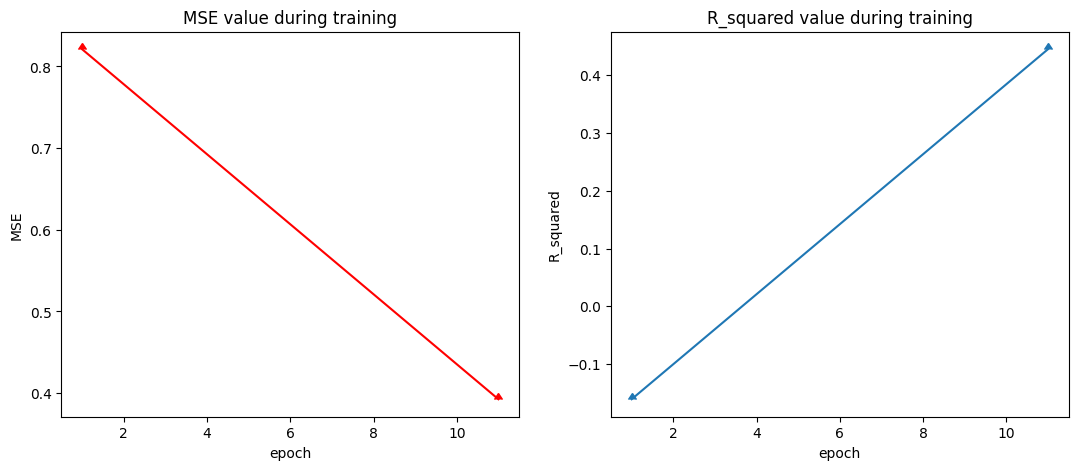

In [40]:
print(f'R-square\t:\t{rs[np.argmax(rs)]}\
      \nRMAE\t\t:\t{np.sqrt(mae[np.argmin(mse)])}\
      \nMAE\t\t:\t{np.min(mae)}\
      \nMSE\t\t:\t{np.min(mse)}')

# visualize loss graph
visual_pts = 10

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(np.arange(1,len(mse)+1, visual_pts), mse[::visual_pts], marker=10, color = 'r')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('MSE value during training')

plt.subplot(1,2,2)
plt.plot(np.arange(1,len(rs)+1, visual_pts), rs[::visual_pts], marker=10)
plt.xlabel('epoch')
plt.ylabel('R_squared')
plt.title('R_squared value during training')
plt.show()



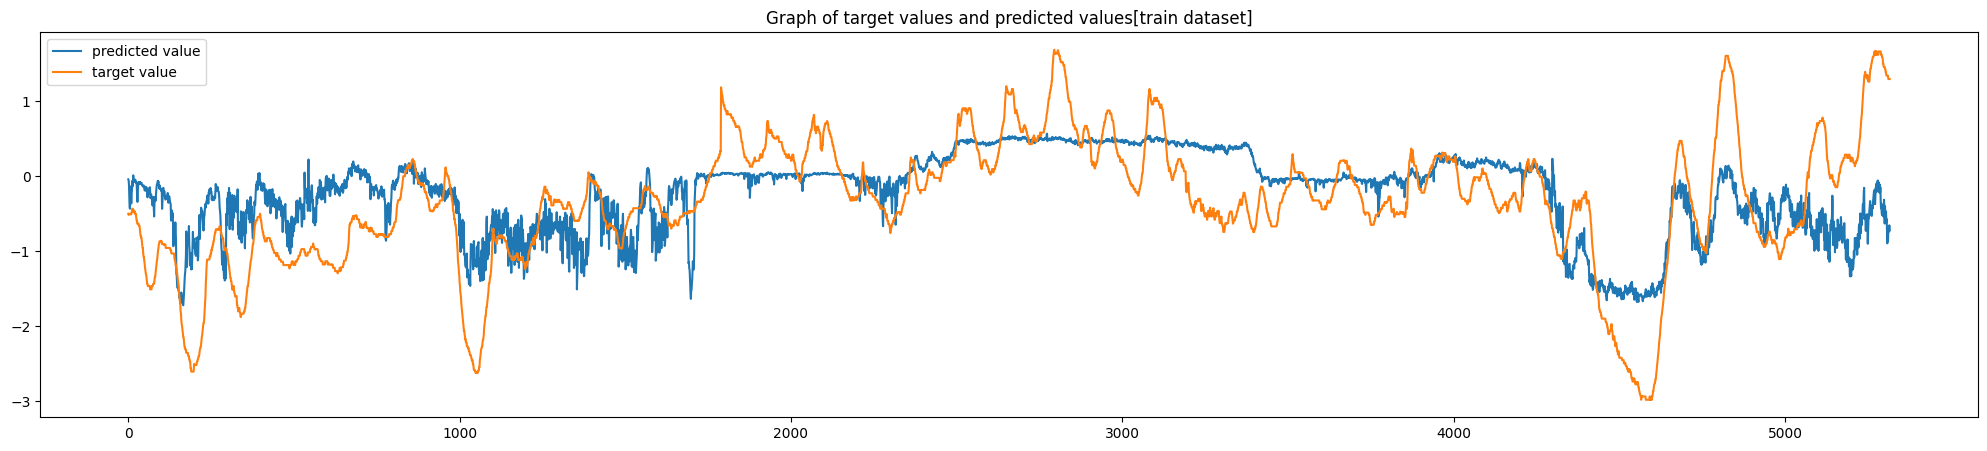

In [41]:
# visualization of model output values
plt.figure(figsize=(25,5))
# plt.xlabel('Data index number')
# plt.ylabel('Feature [A10] value')

# plt.subplot(1,2,1)
plt.plot(y_pred, label = 'predicted value')
plt.plot(trainy, label = 'target value')
plt.title('Graph of target values and predicted values[train dataset]')
plt.legend()

# plt.subplot(1,2,2)
# plt.plot(A2[0])
# plt.title('Graph of predicted values[train dataset]')
plt.show()

In [42]:
# testing
# retrieve the  parameters
tWf, tbf, tWi, tbi, tWc, tbc, tWo, tbo, tWy, tby = parameters

#saving all thte values per input values according to time
tys = []

#preallocating previous hidden and cell state values
h_prev = np.zeros((tWf.shape[0], 1))
c_prev = np.zeros((tWf.shape[0], 1))

for t, X in enumerate(x_scaled): #for each data set of 53 features
    X = X.reshape(-1,1)
    concat = np.concatenate((h_prev, X), axis=0)

    #compute for each gate
    ft = activation('sigmoid', (np.dot(tWf, concat)+tbf))
    it = activation('sigmoid', (np.dot(tWi, concat)+tbi))
    ct = activation('leakyrelu', (np.dot(tWc, concat)+tbc))
    ot = activation('sigmoid', (np.dot(tWo, concat)+tbo))
    c_prev = ft*c_prev + it*ct
    h_prev = ot*activation('tanh', c_prev)
    yt = np.dot(tWy, h_prev) + tby

    tys.append(yt)


y_pred = np.squeeze(tys)

tloss = MSE(y_pred, y_scaled)
tloss_2 = MAE(y_pred, y_scaled)
tacc = r_squared(y_pred, y_scaled)

unscaled_y_true = inverse_Standard(y_scaled, y_mean, y_std)
unscaled_y_pred = inverse_Standard(y_pred, y_mean, y_std)
# r_squared(unscaled_y_pred[0][:4000], unscaled_y_true[:4000])

print(f'Model results for test dataset: \
      \nR-square\t:\t{tacc}\
      \nRMAE\t\t:\t{np.sqrt(tloss_2)}\
      \nMAE\t\t:\t{tloss_2}\
      \nMSE\t\t:\t{tloss}')

Model results for test dataset:       
R-square	:	-0.0182879316566098      
RMAE		:	0.8811316915995056      
MAE		:	0.7763930579410061      
MSE		:	1.0182879316566098


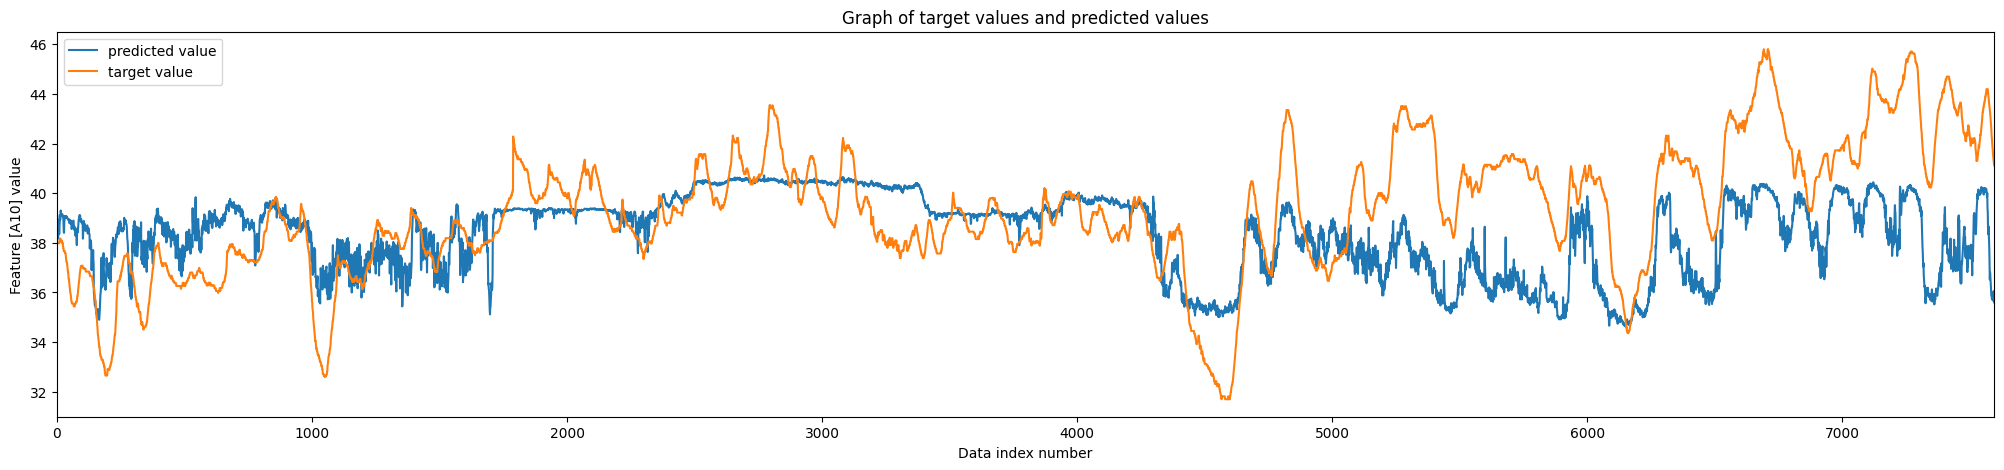

In [43]:
# visualization of model output values and the target values
plt.figure(figsize=(25,5))
plt.xlabel('Data index number')
plt.ylabel('Feature [A10] value')
plt.title('Graph of target values and predicted values')
plt.plot(unscaled_y_pred, label = 'predicted value')
plt.plot(unscaled_y_true, label = 'target value')
plt.xlim([0, len(unscaled_y_true)])
plt.legend()
plt.show()

In [45]:
# # visualize loss graph

# gra = []
# for i in delta.keys():
#     gra.append(delta[i].mean())
# plt.figure(figsize=(13,5))

# plt.plot(np.arange(1,len(gra)+1,), gra, marker=10)
# plt.xlabel('epoch')
# # plt.ylabel('MSE')
# plt.title(f'hidden state value during training')

# plt.show()



AttributeError: 'list' object has no attribute 'mean'

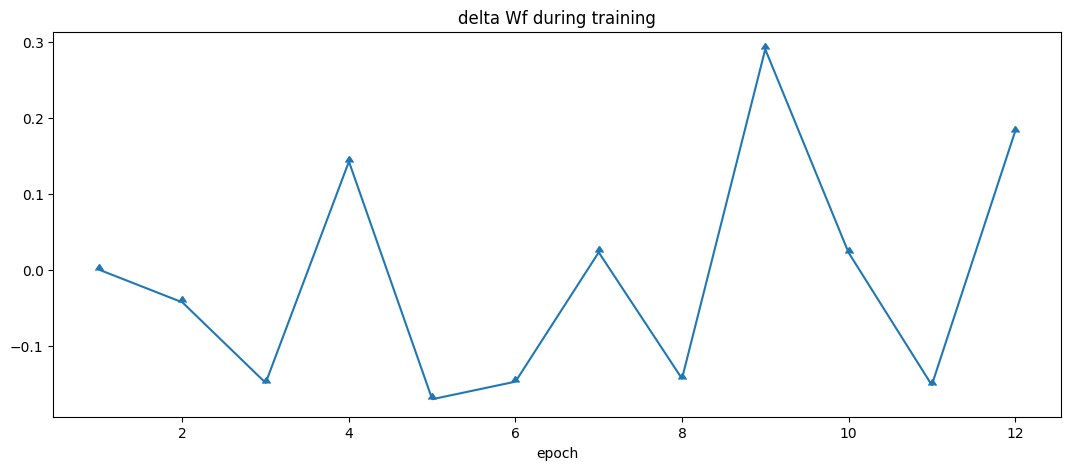

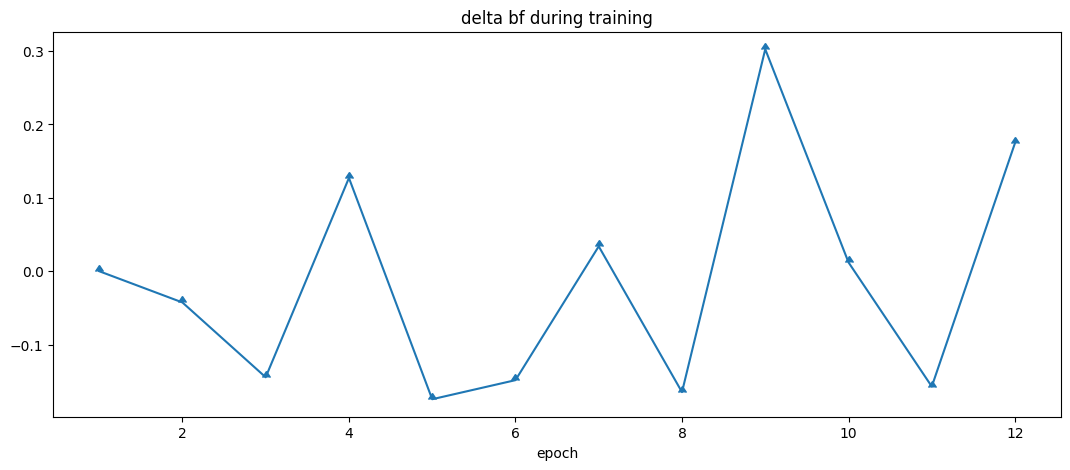

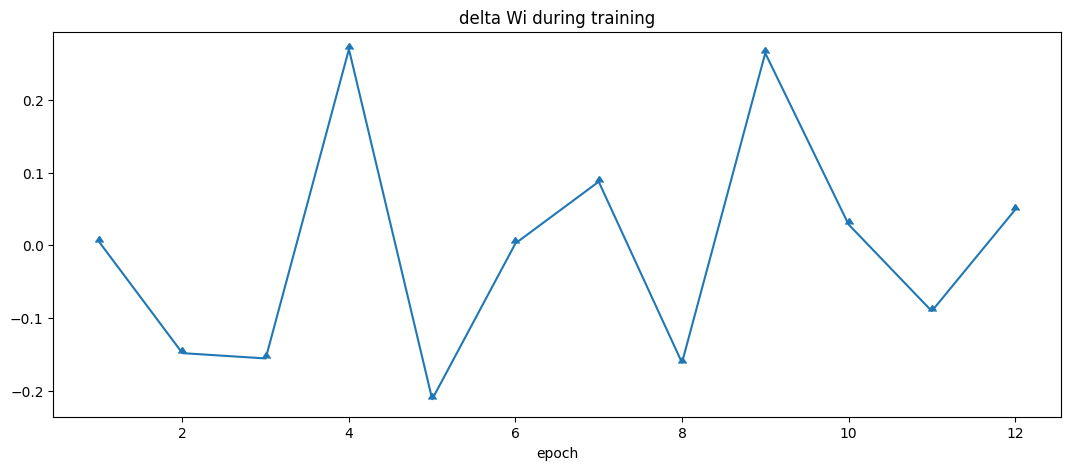

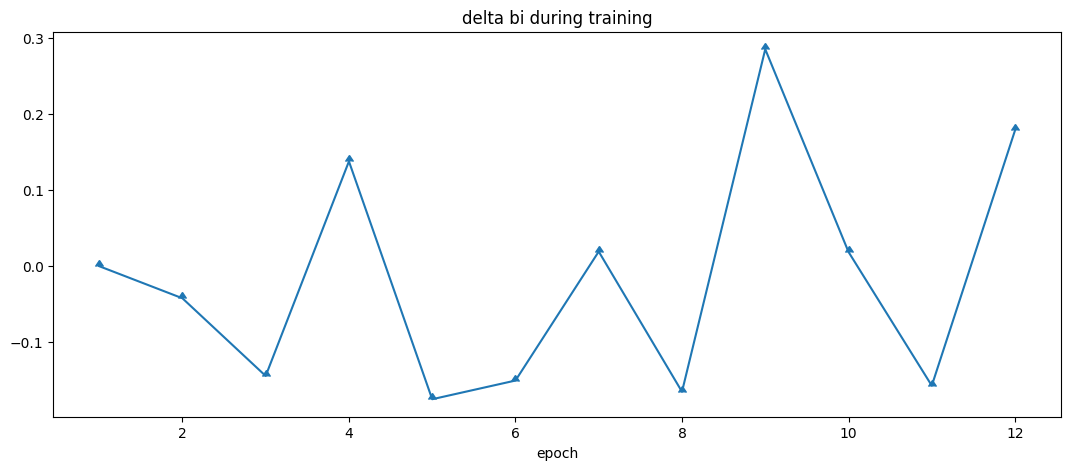

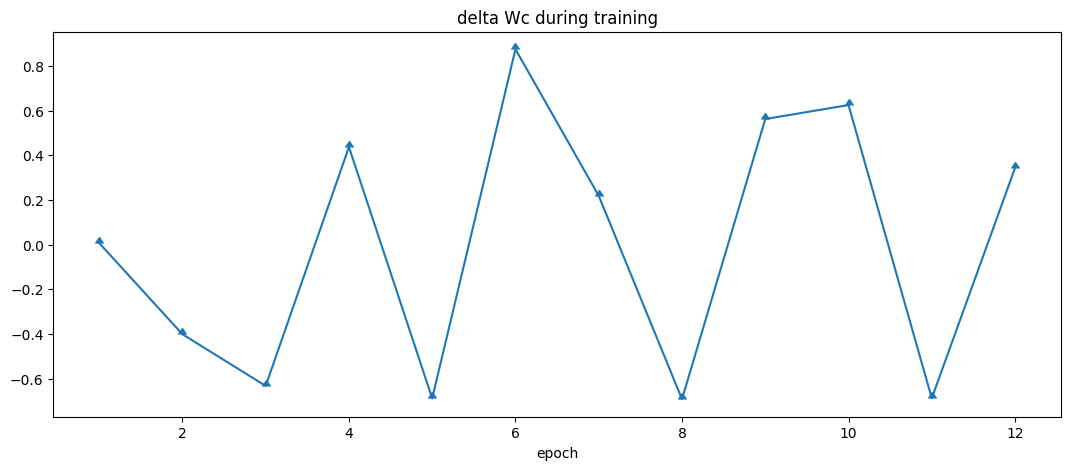

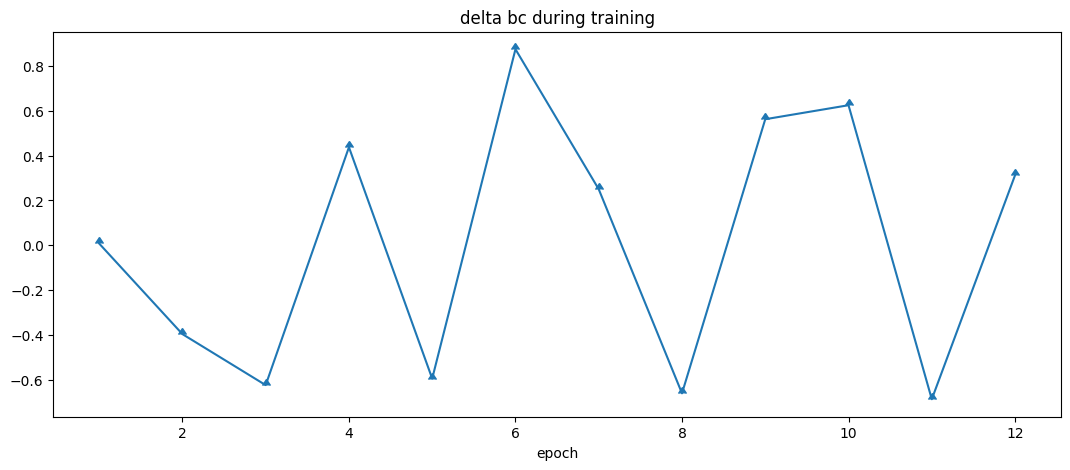

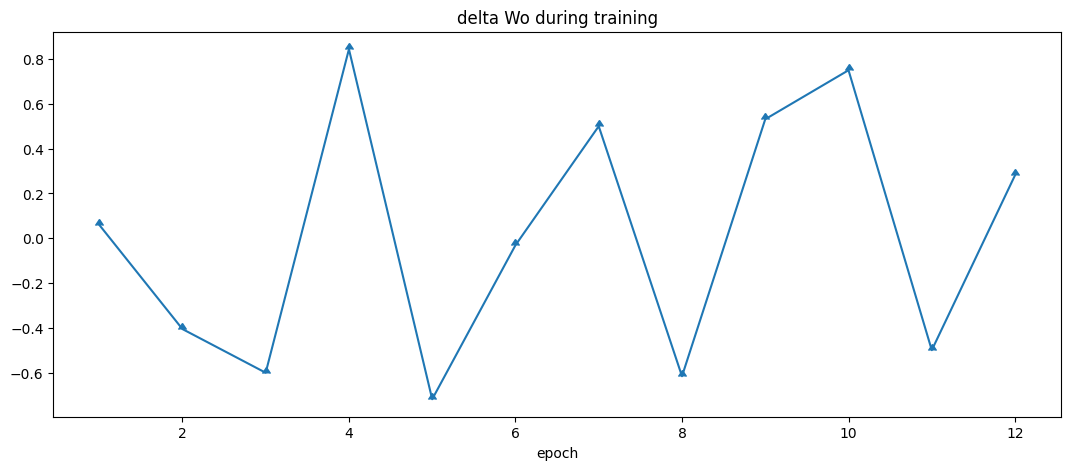

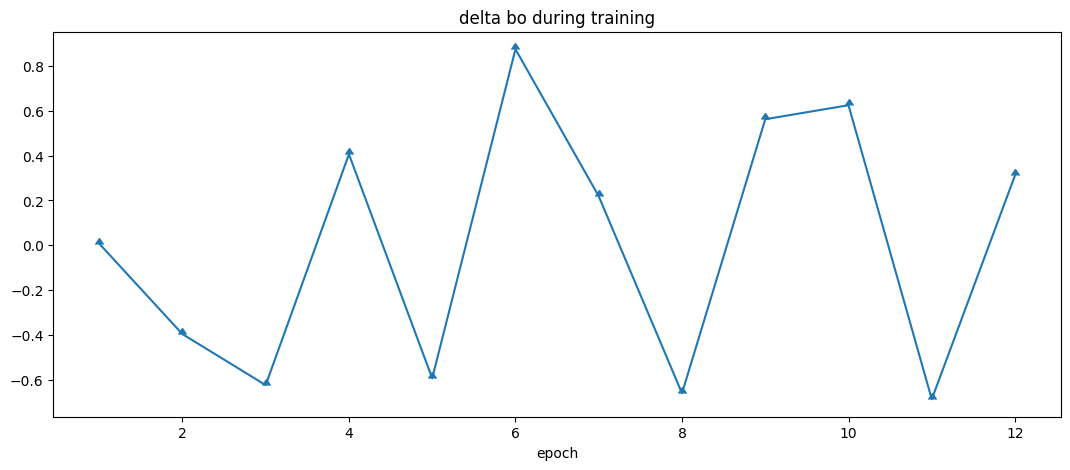

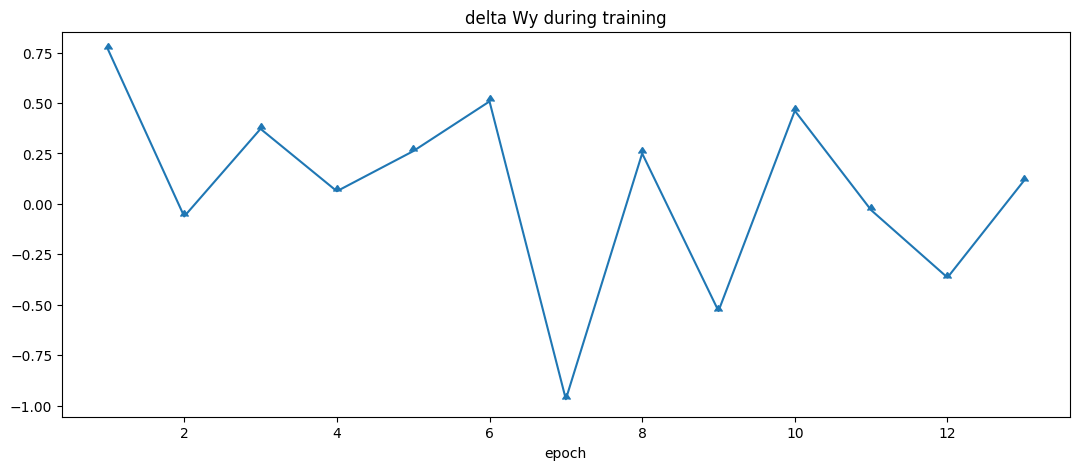

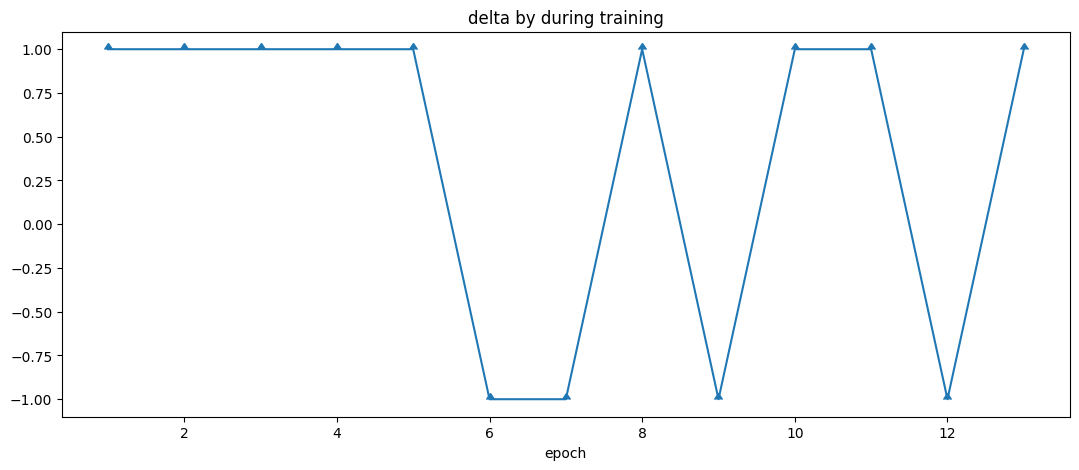

In [49]:
param = ['Wf', 'bf', 'Wi', 'bi', 'Wc', 'bc', 'Wo', 'bo', 'Wy', 'by']
# visualize loss graph
for t in range(10):

    gra = []
    for i in delta.keys():
        gra.append(delta[i][t].mean(axis=1).mean())
    plt.figure(figsize=(13,5))

    plt.plot(np.arange(1,len(gra)+1,), gra, marker=10)
    plt.xlabel('epoch')
    # plt.ylabel('MSE')
    plt.title(f'delta {param[t]} during training')

    plt.show()

